
### Este programa es una copia de barra2.ipynb pero modificado.
### Los archivos de este programa se guardan en la carpeta: /home/ornela/python/barras



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Ángulo de posición de la barra

In [40]:
import h5py
import rotation as rot
import barstrength as strng
import time_conversion as tiempo


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]


snapshot=range(496,60,-1) #SNAPSHOTS

for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.


    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    
#-----------------------------------------------------------------------
#     archivo0 =  open('/home/ornela/python/barras/r50-r90-r200-Mgal_time.dat','a')
#     archivo0.write(str('%03d'% isnap) +'\t'+
#                str('%12.6f'% time) +'\t'+
#                str('%12.6f'% r50) +'\t'+
#                str('%12.6f'% r90) +'\t'+
#                str('%12.6f'% r200) +'\t'+
#                str('%12.6f'% Mgal) +'\n')
#     archivo0.close()
#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm


#calculo el raux
#     raux = 2*r50
#------------------------------------------------------------------------------------
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        raux = r50
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
    elif isnap < 272:
        raux = 0.5
#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,raux)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    mask, = np.where( r < raux)
    
    A2max, rmax, phi = strng.a2max(mstr[mask], xn[mask], yn[mask], 20)

#     phi = phi*180./pi
    
#     if phi < 0:
#         phi2= phi+360
#     else: 
#         phi2= phi
#     phi2 = phi2/2.

#     print phi2

#Guargamos los parámetros en distintos archivos
#----------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/python/barras/A2max_time.dat','a')
    archivo1.write(str('%03d'% isnap) +'\t'+
               str('%12.6f'% time) +'\t'+
               str('%12.6f'% A2max) +'\n')
    archivo1.close()

    archivo2 =  open('/home/ornela/python/barras/Rmax_time.dat','a')
    archivo2.write(str('%03d'% isnap) +'\t'+
               str('%12.6f'% time) +'\t'+
               str('%12.6f'% rmax) +'\n')
    archivo2.close()

#     archivo3 =  open('/home/ornela/python/barras/phi_time.dat','a')
#     archivo3.write(str('%03d'%isnap) +'\t'+
#                str('%12.6f'% time) +'\t'+
#                str('%12.6f'% phi) +'\n')
#     archivo3.close()


### Aca voy a copiar los datos del phi del archivo \home\ornela\barra\barpos_time3.dat

In [57]:
data = np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')
snap = data[:,0]
time = data[:,1]
phi  = data[:,4]

d = np.ndarray([np.size(snap),3])
d[:,0] = snap
d[:,1] = time
d[:,2] = phi

np.savetxt('/home/ornela/python/barras/phi_time.dat', d, fmt=('%03d', '%12.6f', '%12.6f'))

## A2max vs tiempo

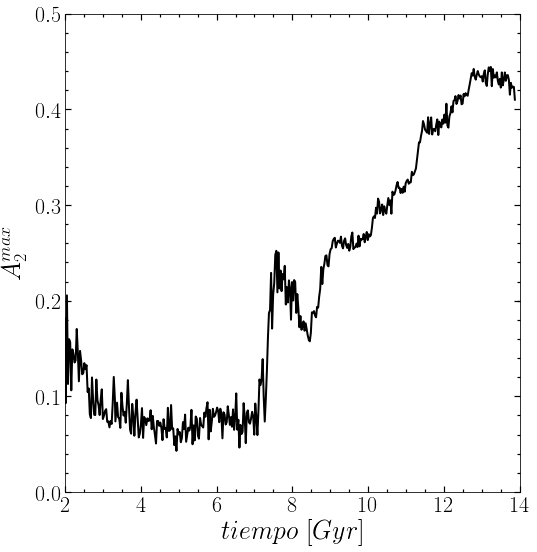

In [2]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

# cm0 = np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')
# t0  = cm0[:,1]
# A2max0 = cm0[:,2]

cm1 = np.loadtxt('/home/ornela/python/barras/A2max_time.dat')
t1  = cm1[:,1]
A2max1 = cm1[:,2]


# time =[]
# A2=[]
# aux=range(0,len(t),1)
# for j in aux:
#     time.append(t[j])
#     A2.append(A2max[j])

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
# ax.plot(t0,A2max0,'-', lw=2, color='r')
ax.plot(t1,A2max1,'-', lw=2, color='k')
ax.set_xlim(2,14)
ax.set_ylim(0.,0.5)
# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w')
# ax.spines['left'].set_color('w')
# ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22) #colors='lightgray')
ax.tick_params('both', length=3, width=1.2, which='minor', direction='in', right='on',top='on')#,colors='w')
ax.tick_params('both', length=6, width=1.2, which='major', direction='in', right='on',top='on')#,colors='w')  
# ax.set_facecolor('silver')
# ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26 )#, color='lightgray')
ax.set_ylabel(r'$A_{2}^{max}$',fontsize=26)#, color='lightgray')
fig.savefig('/home/ornela/Dropbox/Presentaccion_AAA/A2max_time.png', dpi = 100)
plt.show()

## Rmax vs tiempo

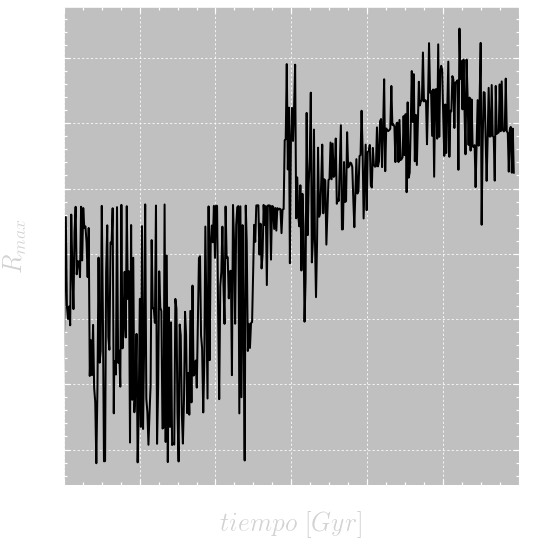

In [2]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

# cm0 = np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')
# t0  = cm0[:,1]
# Rmax0 = cm0[:,3]

cm1 = np.loadtxt('/home/ornela/python/barras/Rmax_time.dat')
t1  = cm1[:,1]
Rmax1 = cm1[:,2]


fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
# ax.plot(t0,Rmax0,'-', lw=2, color='r')
ax.plot(t1,Rmax1,'-', lw=2, color='k')
ax.set_xlim(2,14)
#ax.set_ylim(0.,0.5)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax.set_facecolor('silver')
ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26, color='lightgray')
ax.set_ylabel(r'$R_{max}$',fontsize=26, color='lightgray')
plt.show()

## Phi vs tiempo

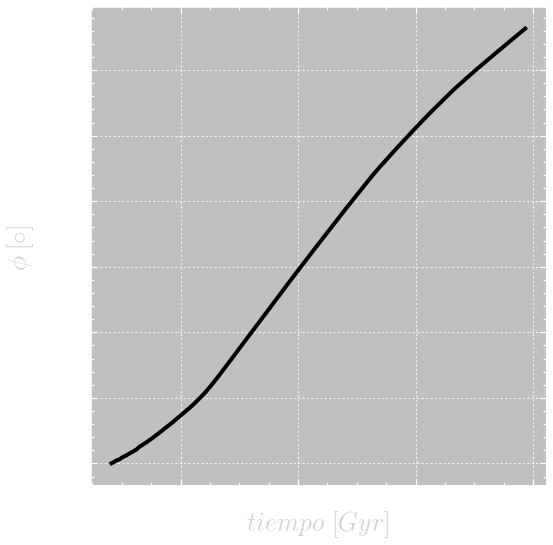

In [2]:
import time_conversion as tiempo
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


# cm0  = np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')
# t0   = cm0[:,1]
# phi0 = cm0[:,4]

# #cuenta para sumar los phi
# #---------------------------------------------------
# mask0, = np.where(t0 > 6.8) # hago un mask porque no tengo el phi para todos los tiempos
# t0     = t0[mask0]
# phi0   = phi0[mask0]

# ang0     = np.zeros(len(phi0)) #redefino mis vectores modificados
# ang0[-1] = phi0[-1]

# j=1
# kk = len(phi0)-1

# for i in range(kk,0,-1):
#     aux = phi0[i]-phi0[i-1]
    
#     if aux > 0:
#         ang0[i-1] = phi0[i-1]+360*j
#         j += 1
        
#     else:
#         ang0[i-1] = phi0[i-1]+360*(j-1)
        
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

cm1  = np.loadtxt('/home/ornela/python/barras/phi_time.dat')
t1   = cm1[:,1]
phi1 = cm1[:,2]

#cuenta para sumar los phi        
#--------------------------------------------------  
mask1, = np.where(t1 > 6.8) 
t1     = t1[mask1]
phi1   = phi1[mask1]
        
ang1 = np.zeros(len(phi1))
ang1[-1] = phi1[-1]

j = 1
kk = len(phi1)-1

for i in range(kk,0,-1):
    aux = phi1[i] - phi1[i-1]
    
    if aux > 0:
        ang1[i-1] = phi1[i-1] + 360*j
        j += 1
        
    else:
        ang1[i-1] = phi1[i-1] + 360*(j-1)
        
# for i in range(aa,-1,-1):
# aux = phi[i+1]-phi[i]
# print aux

# p1 = polyfit(time,phi21,2)
# print p1
 
fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
#ax.plot(t0,ang0,'-', lw=4, color='r')
ax.plot(t1,ang1,'-', lw=4, color='k')
#ax.set_xlim(2,14)
#ax.set_ylim(0.,0.5)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax.set_facecolor('silver')
ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26, color='lightgray')
ax.set_ylabel(r'$\phi \: [\circ]$',fontsize=26, color='lightgray')
plt.show()

#### Guardo phi(t) en un nuevo archivo /home/ornela/python/barras/new_phi_time.dat

In [4]:
dato = np.loadtxt('/home/ornela/python/barras/phi_time.dat')
snap = dato[:,0]
time = dato[:,1]
phi  = dato[:,2]

#cuenta para sumar los phi        
#--------------------------------------------------  
mask, = np.where(time > 6.8) 
snap  = snap[mask]
time  = time[mask]
phi   = phi[mask]
        
ang = np.zeros(len(phi))
ang[-1] = phi[-1]

j = 1
kk = len(phi)-1

for i in range(kk,0,-1):
    aux = phi[i] - phi[i-1]
    
    if aux > 0:
        ang[i-1] = phi[i-1] + 360*j
        j += 1
        
    else:
        ang[i-1] = phi[i-1] + 360*(j-1)
        
d = np.ndarray([np.size(snap),3])
d[:,0] = snap
d[:,1] = time
d[:,2] = ang

np.savetxt('/home/ornela/python/barras/new_phi_time.dat', d, fmt=('%03d', '%12.6f', '%12.6f'))

## Delta_phi/delta_t vs tiempo

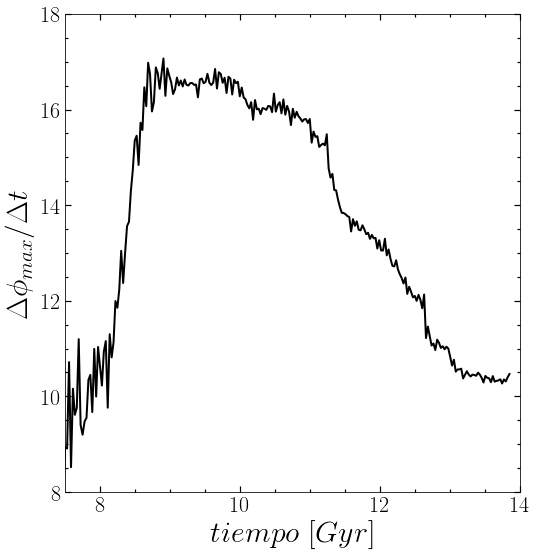

In [6]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm = np.loadtxt('/home/ornela/python/barras/new_phi_time.dat')
time =cm[:,1]
phi =cm[:,2]

kk = len(phi)-1

delta_phi = np.zeros(len(phi))
delta_t = np.zeros(len(phi))
tt = np.zeros(len(phi))

for i in range(kk,0,-1):
    delta_t [i]  = time[i-1] - time[i]
    delta_phi[i] = phi[i-1] - phi[i]
    tt[i] = (time[i-1] + time[i]) / 2.

delta_t   = delta_t[1:]
delta_phi = delta_phi[1:]
tt = tt[1:]

veloc_ang = delta_phi/delta_t

#-------------------------------------------------------------------------------------
# d = np.ndarray([np.size(tt),2])
# d[:,0] = tt
# d[:,1] = veloc_ang

# np.savetxt('/home/ornela/python/barras/derivada_phi_time.dat', d, fmt=('%12.6f', '%12.6f'))
#-------------------------------------------------------------------------------------

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(tt, veloc_ang/360.,'k-', lw=2)
ax.set_xlim(7.5,14)
ax.set_ylim(8,18)
# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w')
# ax.spines['left'].set_color('w')
# ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22)#, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')#,colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')#,colors='w')  
# ax.set_facecolor('silver')
# ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=30)#, color='lightgray')
ax.set_ylabel(r'${\Delta \phi_{max}/\Delta t}$',fontsize=30)#, color='lightgray')
#ax3.twinx() #me hace un eje del otro lado
#ax3.axis('square') #hace el plot cuadrado
#ax3.set_axisbelow(True)
fig.savefig('/home/ornela/Dropbox/Presentaccion_AAA/phimax_time.png', dpi = 100)
plt.show()


# Calculamos Lbar para todos los tiempos

In [6]:
import h5py
import rotation as rot
import barstrength as strng
import time_conversion as tiempo


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]


snapshot=range(496,250,-1) #SNAPSHOTS

for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.


    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa 
#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm
    
#calculo el raux
#     raux = 2*r50
#------------------------------------------------------------------------------------
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        raux = r50
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
    elif isnap < 272:
        raux = 0.5
#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,raux)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
#-----------------------------------------------------------------------------------
    corte1, = np.where( r < raux)
    
    A2max, rmax, phi = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)
    
    corte2, = np. where( r < 2*r50)
    
    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    
    mask, = np.where((rbin >= rmax))
    point = A2[mask]
    rr    = rbin[mask]
    hbar  = 0.15
    resta = point - hbar
    
    for kk,_ in enumerate(point):
        if resta[kk] < 0:/srv/cosmdatc/clues/B64_WM3_186592/LG/GAS_SFR/4096/SNAPS/snap_000
            break
            
    pend = (point[kk] - point[kk-1]) / (rr[kk] - rr[kk-1])
    y0 = (point[kk-1]*rr[kk] - point[kk]*rr[kk-1]) / (rr[kk] - rr[kk-1])
    
    lbar = (hbar - y0)/ pend
    
#    print lbar


#Guargamos los parámetros en distintos archivos
#----------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/python/barras/lbar_time.dat','a')
    archivo1.write(str('%03d'% isnap) +'\t'+
               str('%12.6f'% time) +'\t'+
               str('%12.6f'% lbar) +'\n')
    archivo1.close()
#------------------------------------------------------------------------------------


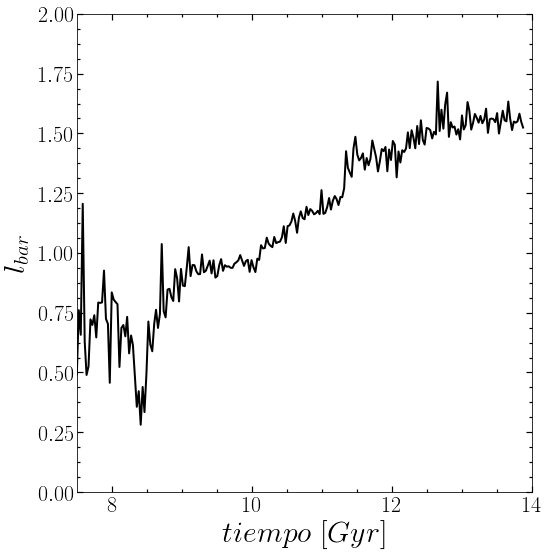

In [7]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm = np.loadtxt('/home/ornela/python/barras/lbar_time.dat')
time = cm[:,1]
lbar = cm[:,2]

cm1 = np.loadtxt('/home/ornela/python/barras/lbar_time2.dat')
time1 = cm1[:,1]
lbar1 = cm1[:,2]

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(time,lbar,'-', lw=2, color='k')
# ax.plot(time1,lbar1,'-', lw=2, color='r')
ax.set_xlim(7.5,14)
ax.set_ylim(0,2)
# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w')
# ax.spines['left'].set_color('w')
# ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22)#, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')#,colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')#,colors='w')  
# ax.set_facecolor('silver')
# ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=30)#, color='lightgray')
ax.set_ylabel(r'$l_{bar}$',fontsize=30)#, color='lightgray')
# fig.savefig('/home/ornela/Dropbox/Presentaccion_AAA/lbar_time.png', dpi = 100)
plt.show()

# Cálculo del Omega con elipsoide

In [6]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
from numpy import matrix
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

cm = np.loadtxt('/home/ornela/python/barras/lbar_time2.dat')
lbar = cm[:,2]

snapshot=range(496,250,-1) #SNAPSHOTS
i = 0
for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.


    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    
#-----------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm


#calculo el raux
#     raux = 2*r50
#------------------------------------------------------------------------------------
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        raux = r50
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
    elif isnap < 272:
        raux = 0.5
#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,raux)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
#--------------------------------------------------------------------------------------    

    corte, = np.where(r<raux)
    
    A2max, rmax, phi = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)
    
    phi = phi/2.
    
#Definimos el tamaño de nuestro elipsoide
    aa=lbar[i]
    bb=0.5*lbar[i]
    cc=0.5*lbar[i]
    
#Hacemos la rotación de las coordenadas
    xx = xn*cos(phi)+yn*sin(phi)
    yy = xn*sin(phi)-yn*cos(phi)
    zz = zn
    RR = np.sqrt((xx/aa)**2+(yy/bb)**2+(zz/cc)**2) # formula del elipsoide
    
    mask, = np.where(RR<1) #seleccionamos las particulas dentro del elipsoide
    
    xn1   = xn[mask]
    yn1   = yn[mask]
    zn1   = zn[mask]
    vxn1  = vxn[mask]
    vyn1  = vyn[mask]
    vzn1  = vzn[mask]
    mstr1 = mstr[mask]
    
    rcil = np.sqrt(xn1**2 + yn1**2)
    
    mask2, = np.where((rcil>0.8*aa) & (rcil<aa)) #tomamos las particulas de la punta del elipsoide

#Calculamos las componentes de momento angular
    Lx = sum((yn1[mask2]*vzn1[mask2] - zn1[mask2]*vyn1[mask2]) * mstr1[mask2])
    Ly = sum((zn1[mask2]*vxn1[mask2] - xn1[mask2]*vzn1[mask2]) * mstr1[mask2])
    Lz = sum((xn1[mask2]*vyn1[mask2] - yn1[mask2]*vxn1[mask2]) * mstr1[mask2])

#Calculamos las componentes del tensor de inercia
    Ixx = sum(mstr1[mask2] * (yn1[mask2]**2 + zn1[mask2]**2))
    Ixy = sum(mstr1[mask2] * xn1[mask2] * yn1[mask2])
    Ixz = sum(mstr1[mask2] * xn1[mask2] * zn1[mask2])
    Iyy = sum(mstr1[mask2] * (xn1[mask2]**2 + zn1[mask2]**2))
    Iyz = sum(mstr1[mask2] * yn1[mask2] * zn1[mask2])
    Izz = sum(mstr1[mask2] * (xn1[mask2]**2 + yn1[mask2]**2))
    
    II = matrix([[Ixx,Ixy,Ixz],[Ixy, Iyy, Iyz], [Ixz, Iyz, Izz]]) #matriz del tensor de inercia
    
    Iinv = II.I #Invertimos la matriz

    omega = Iinv[2,0]*Lx +Iinv[2,1]*Ly + Iinv[2,2]*Lz #velocidad angular del elipsoide
    
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#Lo mismo que arriba pero usamos todas las particulas del elipsoide

#Calculamos las componentes de momento angular
    Lx_total = sum((yn1*vzn1 - zn1*vyn1) * mstr1)
    Ly_total = sum((zn1*vxn1 - xn1*vzn1) * mstr1)
    Lz_total = sum((xn1*vyn1 - yn1*vxn1) * mstr1)

#Calculamos las componentes del tensor de inercia
    Ixx_total = sum(mstr1 * (yn1**2 + zn1**2))
    Ixy_total = sum(mstr1 * xn1 * yn1)
    Ixz_total = sum(mstr1 * xn1 * zn1)
    Iyy_total = sum(mstr1 * (xn1**2 + zn1**2))
    Iyz_total = sum(mstr1 * yn1 * zn1)
    Izz_total = sum(mstr1 * (xn1**2 + yn1**2))
    
    II_total = matrix([[Ixx_total ,Ixy_total,Ixz_total],
                       [Ixy_total, Iyy_total, Iyz_total], 
                       [Ixz_total, Iyz_total, Izz_total]]) #matriz del tensor de inercia
    
    Iinv_total = II_total.I #Invertimos la matriz

#velocidad angular del elipsoide
    omega_total = Iinv_total[2,0]*Lx_total + Iinv_total[2,1]*Ly_total + Iinv_total[2,2]*Lz_total 


# otra forma -----------------------------------------------------------------------------    
#     detI = Ixx*Iyy*Izz + 2*Ixy*Iyz*Ixz - Iyy*Ixz**2 - Ixx*Iyz**2 - Izz*Ixy**2
#     print detI
    
#     a13 = (Ixy*Iyz-Ixz*Iyy)/detI
#     a23 = (Ixz*Ixy-Iyz*Ixx)/detI
#     a33 = (Ixx*Iyy-Ixy**2)/detI
#     print a33
    #omegaz = median(Lz/Izz)
#     print omegaZ
    
#     omega2 = (xn[mask]*vyn[mask] - yn[mask]*vxn[mask])/rcil[mask]**2
#     omega3 = median(omega2)
    
#     VT =(xn[mask]*vyn[mask] - yn[mask]*vxn[mask])/rcil[mask]
#--------------------------------------------------------------------------------------

#Guargamos los parámetros en distintos archivos
#-------------------------------------------------------------------------------------
#     archivo1 =  open('/home/ornela/python/barras/omegabar_time3.dat','a')
#     archivo1.write(str('%03d'% isnap) +'\t'+
#                str('%12.6f'% time) +'\t'+
#                str('%12.6f'% omega) +'\n')
#     archivo1.close()
    
    archivo2 =  open('/home/ornela/python/barras/total_omegabar_time2.dat','a')
    archivo2.write(str('%03d'% isnap) +'\t'+
               str('%12.6f'% time) +'\t'+
               str('%12.6f'% omega_total) +'\n')
    archivo2.close()
#--------------------------------------------------------------------------------------
    i += 1
# el omegabar_time3 tiene phi=phi/2 los otros no!
# total_omegabar_time2.dat tiene phi/2

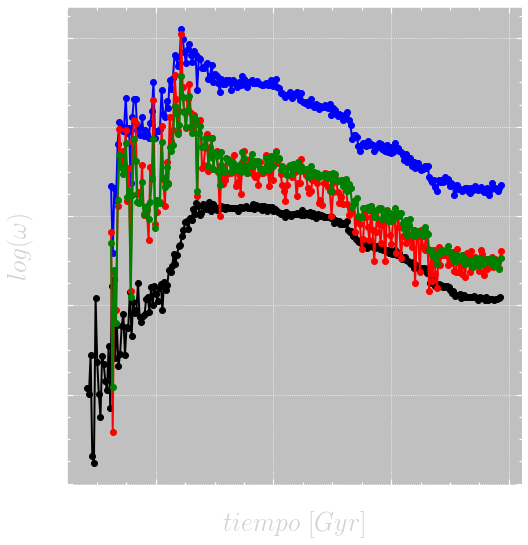

In [13]:
import time_conversion as tiempo
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm0    = np.loadtxt('/home/ornela/python/barras/derivada_phi_time.dat')
t0     = cm0[:,0]
omega0 = cm0[:,1]

cm1    = np.loadtxt('/home/ornela/python/barras/omegabar_time.dat')
t1     = cm1[:,1]
omega1 = cm1[:,2]

cm2    = np.loadtxt('/home/ornela/python/barras/omegabar_time2.dat')
t2     = cm2[:,1]
omega2 = cm2[:,2]

cm3    = np.loadtxt('/home/ornela/python/barras/omegabar_time3.dat')
t3     = cm3[:,1]
omega3 = cm3[:,2]

cm4    = np.loadtxt('/home/ornela/python/barras/total_omegabar_time2.dat')
t4     = cm4[:,1]
omega4 = cm4[:,2]

cm11=np.loadtxt('/home/ornela/python/barra/momento_ang_fin.dat')
t11 =cm11[:,1]
omega11 =cm11[:,2]

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(t0,log10(omega0/360.),'ko-', lw=2)
ax.plot(t4,log10(omega4/(2.*pi)),'bo-', lw=2)
ax.plot(t2,log10(omega2/(2.*pi)),'ro-', lw=2)
ax.plot(t3,log10(omega3/(2.*pi)),'go-', lw=2)
#ax.plot(t2,log10(omega2/(2*pi)),'go-', lw=2)
#ax.plot(tZ,log10(omegaZ/(2.*pi)),'ko-', lw=2)
# ax3.plot(tbar,log10(omega_bar/1.022712086),'go-', lw=2)
#ax3.plot(tt,polyval(p2,tt), 'r-', lw=2)
#ax3.set_xlim(7.5,14)
#ax3.set_ylim(1.7,2.5)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax.set_facecolor('silver')
ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26, color='lightgray')
ax.set_ylabel(r'$log(\omega)$',fontsize=26, color='lightgray')
#ax3.twinx() #me hace un eje del otro lado
#ax3.axis('square') #hace el plot cuadrado
#ax3.set_axisbelow(True)
plt.show()


## R50 vs tiempo

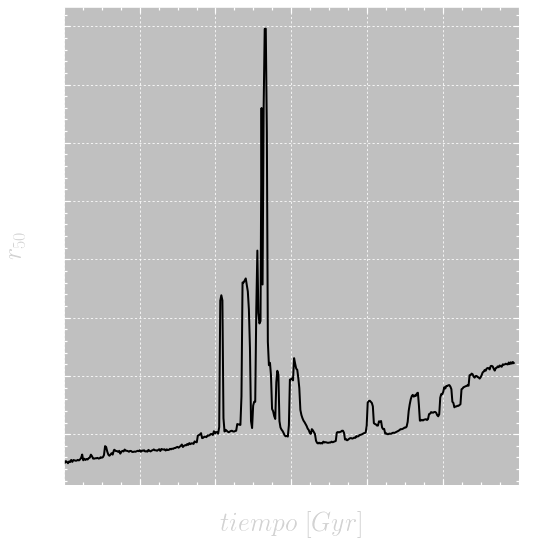

In [5]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

# cm0 = np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')
# t0  = cm0[:,1]
# A2max0 = cm0[:,2]

cm1 = np.loadtxt('/home/ornela/python/barras/r50-r90-r200-Mgal_time.dat')
t1  = cm1[:,1]
r50 = cm1[:,2]


# time =[]
# A2=[]
# aux=range(0,len(t),1)
# for j in aux:
#     time.append(t[j])
#     A2.append(A2max[j])

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
# ax.plot(t0,A2max0,'-', lw=2, color='r')
ax.plot(t1,r50,'-', lw=2, color='k')
ax.set_xlim(2,14)
#ax.set_ylim(0.,0.5)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax.set_facecolor('silver')
ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26, color='lightgray')
ax.set_ylabel(r'$r_{50}$',fontsize=26, color='lightgray')
plt.show()

#  Momento angular vs tiempo

In [6]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
from numpy import matrix
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

cm = np.loadtxt('/home/ornela/python/barras/lbar_time2.dat')
lbar = cm[:,2]


snapshot=range(496,60,-1) #SNAPSHOTS
i=0
for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value    
    vstr = snap['subhalo_000/Str/Velocities'].value
    
    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    mdrk = snap['subhalo_000/Drk/Masses'].value
    vdrk  = snap['subhalo_000/Drk/Velocities'].value
    
    pgas = snap['subhalo_000/Gas/Coordinates'].value
    mgas = snap['subhalo_000/Gas/Masses'].value
    vgas  = snap['subhalo_000/Gas/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    rstr = np.sqrt(xstr**2 + ystr**2 + zstr**2)
    
    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2 + ydrk**2 + zdrk**2)
    
    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2 + ygas**2 + zgas**2)
    
#paso las velocidades a unidades físicas
    vstr_x = vstr[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    vstr_y = vstr[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    vstr_z = vstr[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
    
    vdrk_x = vdrk[:,0] *np.sqrt(aexp[isnap]) + Ht *xdrk/1000.
    vdrk_y = vdrk[:,1] *np.sqrt(aexp[isnap]) + Ht *ydrk/1000.
    vdrk_z = vdrk[:,2] *np.sqrt(aexp[isnap]) + Ht *zdrk/1000.
    
    vgas_x = vgas[:,0] *np.sqrt(aexp[isnap]) + Ht *xgas/1000.
    vgas_y = vgas[:,1] *np.sqrt(aexp[isnap]) + Ht *ygas/1000.
    vgas_z = vgas[:,2] *np.sqrt(aexp[isnap]) + Ht *zgas/1000.


#masa a unidades físicas
    mstr = mstr/h     
    mdrk = mdrk/h
    mgas = mgas/h
    
    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia
    
    limit = np.where(rstr<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(rstr[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(rstr[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(rstr < r50)
    
    vstr_xcm = sum(mstr[veloc]*vstr_x[veloc])/sum(mstr[veloc])
    vstr_ycm = sum(mstr[veloc]*vstr_y[veloc])/sum(mstr[veloc])
    vstr_zcm = sum(mstr[veloc]*vstr_z[veloc])/sum(mstr[veloc])
    
    veloc2, = np.where(rdrk < r50)
    
    vdrk_xcm = sum(mdrk[veloc2]*vdrk_x[veloc2])/sum(mdrk[veloc2])
    vdrk_ycm = sum(mdrk[veloc2]*vdrk_y[veloc2])/sum(mdrk[veloc2])
    vdrk_zcm = sum(mdrk[veloc2]*vdrk_z[veloc2])/sum(mdrk[veloc2])
    
    veloc3, = np.where(rgas < r50)
    
    vgas_xcm = sum(mgas[veloc3]*vgas_x[veloc3])/sum(mgas[veloc3])
    vgas_ycm = sum(mgas[veloc3]*vgas_y[veloc3])/sum(mgas[veloc3])
    vgas_zcm = sum(mgas[veloc3]*vgas_z[veloc3])/sum(mgas[veloc3])


#velocidades de las estrellas respecto del centro de masa de la galaxia
    vstrx = vstr_x - vstr_xcm
    vstry = vstr_y - vstr_ycm
    vstrz = vstr_z - vstr_zcm
    
    vdrkx = vdrk_x - vdrk_xcm
    vdrky = vdrk_y - vdrk_ycm
    vdrkz = vdrk_z - vdrk_zcm
    
    vgasx = vgas_x - vgas_xcm
    vgasy = vgas_y - vgas_ycm
    vgasz = vgas_z - vgas_zcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular
    if isnap == 496:
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vstrx,vstry,vstrz,2*r50)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr
    vxn_str = e1x*vstrx + e1y*vstry + e1z*vstrz
    vyn_str = e2x*vstrx + e2y*vstry + e2z*vstrz
    vzn_str = e3x*vstrx + e3y*vstry + e3z*vstrz
    
    xn_drk = e1x*xdrk + e1y*ydrk + e1z*zdrk
    yn_drk = e2x*xdrk + e2y*ydrk + e2z*zdrk
    zn_drk = e3x*xdrk + e3y*ydrk + e3z*zdrk
    vxn_drk = e1x*vdrkx + e1y*vdrky + e1z*vdrkz
    vyn_drk = e2x*vdrkx + e2y*vdrky + e2z*vdrkz
    vzn_drk = e3x*vdrkx + e3y*vdrky + e3z*vdrkz
    
    xn_gas = e1x*xgas + e1y*ygas + e1z*zgas
    yn_gas = e2x*xgas + e2y*ygas + e2z*zgas
    zn_gas = e3x*xgas + e3y*ygas + e3z*zgas
    vxn_gas = e1x*vgasx + e1y*vgasy + e1z*vgasz
    vyn_gas = e2x*vgasx + e2y*vgasy + e2z*vgasz
    vzn_gas = e3x*vgasx + e3y*vgasy + e3z*vgasz
    
#-------------------------------------------------------------------------------------- 
    lim_str, = np.where ( (rstr < r200*1/3.) )
    lim_drk, = np.where ( (rdrk < r200*1/3.) )
    lim_gas, = np.where ( (rgas < r200*1/3.) )

#Calculamos las componentes de momento angular
    Lx_str = sum((yn_str[lim_str]*vzn_str[lim_str] - zn_str[lim_str]*vyn_str[lim_str])* mstr[lim_str])
    Ly_str = sum((zn_str[lim_str]*vxn_str[lim_str] - xn_str[lim_str]*vzn_str[lim_str])* mstr[lim_str])
    Lz_str = sum((xn_str[lim_str]*vyn_str[lim_str] - yn_str[lim_str]*vxn_str[lim_str])* mstr[lim_str])
    
    Lx_str = Lx_str/sum(mstr[lim_str])
    Ly_str = Ly_str/sum(mstr[lim_str])
    Lz_str = Lz_str/sum(mstr[lim_str])
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    
    Lx_drk = sum((yn_drk[lim_drk]*vzn_drk[lim_drk] - zn_drk[lim_drk]*vyn_drk[lim_drk])* mdrk[lim_drk])
    Ly_drk = sum((zn_drk[lim_drk]*vxn_drk[lim_drk] - xn_drk[lim_drk]*vzn_drk[lim_drk])* mdrk[lim_drk])
    Lz_drk = sum((xn_drk[lim_drk]*vyn_drk[lim_drk] - yn_drk[lim_drk]*vxn_drk[lim_drk])* mdrk[lim_drk])
    
    Lx_drk = Lx_drk/sum(mdrk[lim_drk])
    Ly_drk = Ly_drk/sum(mdrk[lim_drk])
    Lz_drk = Lz_drk/sum(mdrk[lim_drk])
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    Lx_gas = sum((yn_gas[lim_gas]*vzn_gas[lim_gas] - zn_gas[lim_gas]*vyn_gas[lim_gas])* mgas[lim_gas])
    Ly_gas = sum((zn_gas[lim_gas]*vxn_gas[lim_gas] - xn_gas[lim_gas]*vzn_gas[lim_gas])* mgas[lim_gas])
    Lz_gas = sum((xn_gas[lim_gas]*vyn_gas[lim_gas] - yn_gas[lim_gas]*vxn_gas[lim_gas])* mgas[lim_gas])
    
    Lx_gas = Lx_gas/sum(mgas[lim_gas])
    Ly_gas = Ly_gas/sum(mgas[lim_gas])
    Lz_gas = Lz_gas/sum(mgas[lim_gas])
    

#Guargamos los parámetros en distintos archivos
#-------------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/python/barras/Lstr_time14.dat','a')
    archivo1.write(str('%03d'% isnap) +'\t'+
                str('%12.6f'% time) +'\t'+
                str('%12.6f'% Lx_str) +'\t'+
                str('%12.6f'% Ly_str) +'\t'+
                str('%12.6f'% Lz_str) +'\n')
    archivo1.close()
    
    archivo2 =  open('/home/ornela/python/barras/Ldrk_time14.dat','a')
    archivo2.write(str('%03d'% isnap) +'\t'+
                str('%12.6f'% time) +'\t'+
                str('%12.6f'% Lx_drk) +'\t'+
                str('%12.6f'% Ly_drk) +'\t'+
                str('%12.6f'% Lz_drk) +'\n')
    archivo2.close()
    
    archivo3 =  open('/home/ornela/python/barras/Lgas_time14.dat','a')
    archivo3.write(str('%03d'% isnap) +'\t'+
                str('%12.6f'% time) +'\t'+
                str('%12.6f'% Lx_gas) +'\t'+
                str('%12.6f'% Ly_gas) +'\t'+
                str('%12.6f'% Lz_gas) +'\n')
    archivo3.close() 
#--------------------------------------------------------------------------------------
    i += 1
# el dos es el momento angular (r<5), el que no tiene numero es el L especifico!
#el 3 es en r<lbar
#el 4 es en r<2
#el 5 es dividido a la masa total en r<2
#el 6 es dividido a la masa total en r<lbar
#el 7 es en un anillo entre r90 y rgal
#el 8 es un anillo entre rgal y 0.8*rgal
#el 9 es dividido a la masa total en r < rgal
#el 10 es dividido a la masa total en r < 15
#el 11 es dividido la masa total en r<r200
#el 12 es igual que el 11 pero rotado en z=0
#el 13 es dividido la masa total en r<r200*1/3
#el 14 es el 12 pero en r<r200*1/3

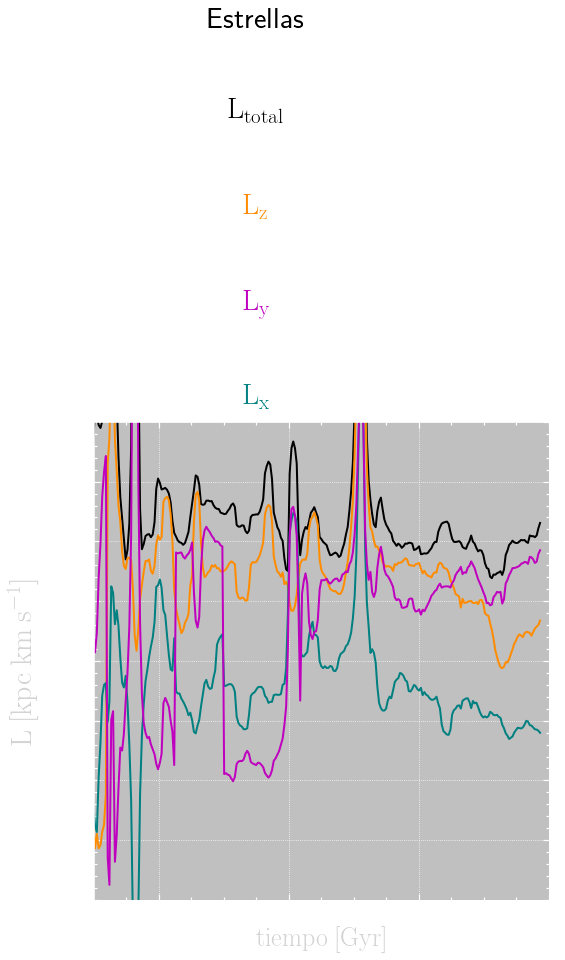

In [29]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm0 = np.loadtxt('/home/ornela/python/barras/Lstr_time9.dat')
time0  = cm0[:,1]
Lx_str = cm0[:,2]
Ly_str = cm0[:,3]
Lz_str = cm0[:,4]

cm1 = np.loadtxt('/home/ornela/python/barras/Ldrk_time9.dat')
time1  = cm1[:,1]
Lx_drk = cm1[:,2]
Ly_drk = cm1[:,3]
Lz_drk = cm1[:,4]

# cm2 = np.loadtxt('/home/ornela/python/barras/Lgas_time8.dat')
# time2  = cm2[:,1]
# Lx_gas = cm2[:,2]
# Ly_gas = cm2[:,3]
# Lz_gas = cm2[:,4]

Lt_str = np.sqrt(Lx_str**2 + Ly_str**2 + Lz_str**2)

Lt_drk = np.sqrt(Lx_drk**2 + Ly_drk**2 + Lz_drk**2)

# Lt_gas = np.sqrt(Lx_gas**2 + Ly_gas**2 + Lz_gas**2)


fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
# ax.plot(time2,Lt_gas,'-', lw=2, color='k')
# ax.plot(time2,Lz_gas,'-', lw=2, color='darkorange')
# ax.plot(time2,Lx_gas,'-', lw=2, color='teal')
# ax.plot(time2,Ly_gas,'-', lw=2, color='m')
# ax.plot(time0,Lt_str,'-', lw=2, color='k')
# ax.plot(time0,Lz_str,'-', lw=2, color='darkorange')
# ax.plot(time0,Lx_str,'-', lw=2, color='teal')
# ax.plot(time0,Ly_str,'-', lw=2, color='m')
# ax.plot(time1,Lt_drk,'-', lw=2, color='k')
# ax.plot(time1,Lz_drk,'-', lw=2, color='darkorange')
# ax.plot(time1,Lx_drk,'-', lw=2, color='teal')
# ax.plot(time1,Ly_drk,'-', lw=2, color='m')
ax.set_xlim(7,14)
ax.set_ylim(-200,200)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax.set_facecolor('silver')
ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$\rm{tiempo\:[Gyr]}$', fontsize=26, color='lightgray')
ax.set_ylabel(r'$\rm{L\:[kpc\:km\:s^{-1}]}$',fontsize=30, color='lightgray')
ax.text(9.5,530,'Estrellas', color='k', fontsize=30, ha='center')
ax.text(9.5,450,r'$\rm{L_{total}}$', color='k', fontsize=30, ha='center')
ax.text(9.5,370,r'$\rm{L_z}$', color='darkorange',fontsize=30, ha='center')
ax.text(9.5,290,r'$\rm{L_y}$', color='m', fontsize=30, ha='center')
ax.text(9.5,210,r'$\rm{L_x}$', color='teal', fontsize=30, ha='center')
plt.show()

## Test de veloc tangencial

In [20]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
from numpy import matrix
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

cm = np.loadtxt('/home/ornela/python/barras/lbar_time2.dat')
lbar = cm[:,2]


snapshot=range(496,495,-1) #SNAPSHOTS
i=0
for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vstr = snap['subhalo_000/Str/Velocities'].value
    
#     pdrk = snap['subhalo_000/Drk/Coordinates'].value
#     mdrk = snap['subhalo_000/Drk/Masses'].value
#     vdrk  = snap['subhalo_000/Drk/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    rstr = np.sqrt(xstr**2 + ystr**2 + zstr**2)
    
#     xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
#     ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
#     zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
#     rdrk = np.sqrt(xdrk**2 + ydrk**2 + zdrk**2)
    
#paso las velocidades a unidades físicas
    vstr_x = vstr[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    vstr_y = vstr[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    vstr_z = vstr[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
    
#     vdrk_x = vdrk[:,0] *np.sqrt(aexp[isnap]) + Ht *xdrk/1000.
#     vdrk_y = vdrk[:,1] *np.sqrt(aexp[isnap]) + Ht *ydrk/1000.
#     vdrk_z = vdrk[:,2] *np.sqrt(aexp[isnap]) + Ht *zdrk/1000.


#masa a unidades físicas
    mstr = mstr/h     
    mdrk = mdrk/h
    
    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia
    
    limit = np.where(rstr<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(rstr[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(rstr[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(rstr < r50)
    
    vstr_xcm = sum(mstr[veloc]*vstr_x[veloc])/sum(mstr[veloc])
    vstr_ycm = sum(mstr[veloc]*vstr_y[veloc])/sum(mstr[veloc])
    vstr_zcm = sum(mstr[veloc]*vstr_z[veloc])/sum(mstr[veloc])
    
#     veloc2, = np.where(rdrk < r50)
    
#     vdrk_xcm = sum(mdrk[veloc2]*vdrk_x[veloc2])/sum(mdrk[veloc2])
#     vdrk_ycm = sum(mdrk[veloc2]*vdrk_y[veloc2])/sum(mdrk[veloc2])
#     vdrk_zcm = sum(mdrk[veloc2]*vdrk_z[veloc2])/sum(mdrk[veloc2])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vstrx = vstr_x - vstr_xcm
    vstry = vstr_y - vstr_ycm
    vstrz = vstr_z - vstr_zcm
    
#     vdrkx = vdrk_x - vdrk_xcm
#     vdrky = vdrk_y - vdrk_ycm
#     vdrkz = vdrk_z - vdrk_zcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vstrx,vstry,vstrz,2*r50)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr
    vxn_str = e1x*vstrx + e1y*vstry + e1z*vstrz
    vyn_str = e2x*vstrx + e2y*vstry + e2z*vstrz
    vzn_str = e3x*vstrx + e3y*vstry + e3z*vstrz
    
#     xn_drk = e1x*xdrk + e1y*ydrk + e1z*zdrk
#     yn_drk = e2x*xdrk + e2y*ydrk + e2z*zdrk
#     zn_drk = e3x*xdrk + e3y*ydrk + e3z*zdrk
#     vxn_drk = e1x*vdrkx + e1y*vdrky + e1z*vdrkz
#     vyn_drk = e2x*vdrkx + e2y*vdrky + e2z*vdrkz
#     vzn_drk = e3x*vdrkx + e3y*vdrky + e3z*vdrkz
    
#-------------------------------------------------------------------------------------- 
    lim_str, = np.where ( (rstr < 2) & (rstr > 1.8) )
#     lim_drk, = np.where ( (rstr < rgal) & (rstr > rgal*0.8) )

#Calculamos las componentes de momento angular
    Lx_str = sum((yn_str[lim_str]*vzn_str[lim_str] - zn_str[lim_str]*vyn_str[lim_str])* mstr[lim_str])
    Ly_str = sum((zn_str[lim_str]*vxn_str[lim_str] - xn_str[lim_str]*vzn_str[lim_str])* mstr[lim_str])
    Lz_str = sum((xn_str[lim_str]*vyn_str[lim_str] - yn_str[lim_str]*vxn_str[lim_str])* mstr[lim_str])
    
    Lx_str = Lx_str/sum(mstr[lim_str])
    Ly_str = Ly_str/sum(mstr[lim_str])
    Lz_str = Lz_str/sum(mstr[lim_str])
    
#     Lx_drk = sum((yn_drk[lim_drk]*vzn_drk[lim_drk] - zn_drk[lim_drk]*vyn_drk[lim_drk])* mdrk[lim_drk])
#     Ly_drk = sum((zn_drk[lim_drk]*vxn_drk[lim_drk] - xn_drk[lim_drk]*vzn_drk[lim_drk])* mdrk[lim_drk])
#     Lz_drk = sum((xn_drk[lim_drk]*vyn_drk[lim_drk] - yn_drk[lim_drk]*vxn_drk[lim_drk])* mdrk[lim_drk])
    
#     Lx_drk = Lx_drk/sum(mdrk[lim_drk])
#     Ly_drk = Ly_drk/sum(mdrk[lim_drk])
#     Lz_drk = Lz_drk/sum(mdrk[lim_drk])
    
    Rcirc = np.sqrt(xn_str[lim_str]**2 + yn_str[lim_str]**2)
    VT = sum((xn_str[lim_str]*vyn_str[lim_str] - yn_str[lim_str]*vxn_str[lim_str])/Rcirc)/len(xn_str[lim_str])
    
    print 'Rcirc =', median(Rcirc)
    print 'VT =', VT
    print 'Lz_str =', Lz_str



Rcirc = 1.80369
VT = 79.9047237051
Lz_str = 143.656
